# General

## Introduction

Notebook containing **software-control** EEG processing pipeline. Goal is a general purpose discrimination system for EEG data, ie. the ability to classify sample EEG traces to a few given categories.

*Authors: Dasheng Bi*

## Quick Operations

In [1]:
# Libraries for data import, preprocessing
import numpy as np
import pandas as pd

# Visualization, clustering
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Path properties
train_root = 'csv1/'
test_root = 'csv2/'
prefix = 'db-rec-'
label = ['GO_', 'STOP_']
train_number = range(1, 6)
test_number = range(1, 4)
suffix = '.csv'

# Data properties
SAMPLE_FREQ = 256
INTERVAL = 0.5
# N_COMPONENTS = 4 # raw data
N_COMPONENTS = 20 # filtered DTABG components
TRAIN_SAMPLES = 60
TEST_SAMPLES = 36

# Data Loading, Preprocessing

## Imports

In [ ]:
# Libraries for data import, preprocessing
import numpy as np
import pandas as pd

In [ ]:
# Visualization, clustering
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

## Path Configuration

In [ ]:
# Path properties
root = 'csv1/'
prefix = 'db-rec-'
label = ['GO_', 'STOP_']
number = range(1, 6)
suffix = '.csv'

## Read Data, Select Columns

### General Attributes

In [ ]:
SAMPLE_FREQ = 256
INTERVAL = 0.5

# N_COMPONENTS = 4 # raw data
N_COMPONENTS = 20 # filtered DTABG components

TRAIN_SAMPLES = 60
TEST_SAMPLES = 8

### Explore Data Format

In [ ]:
path = root + prefix + label[0] + str(number[0]) + suffix
df = pd.read_csv(path)
print(df.columns)
df = df.drop(columns=df.columns[21:])
print(df.columns)
df = df.drop(columns=df.columns[0])
print(df.columns)
print(df.shape)

### Read in Training Data

In [45]:
data_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
# print(data_stack)
# print(data_stack.shape)
for l in label:
    for trial in train_number:
        path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.

        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
    #         print(np.argwhere(np.isnan(raw_vals)))
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
#         print(data_stack.shape)
df_stack = pd.DataFrame(data_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

# Labels
train_labels = [1] * TRAIN_SAMPLES + [0] * TRAIN_SAMPLES

Dropped NaN: 
 [[723   0]
 [723   1]
 [723   2]
 [723   3]
 [723   4]
 [723   5]
 [723   6]
 [723   7]
 [723   8]
 [723   9]
 [723  10]
 [723  11]
 [723  12]
 [723  13]
 [723  14]
 [723  15]
 [723  16]
 [723  17]
 [723  18]
 [723  19]]
Dropped NaN: 
 [[ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]]
Dropped NaN: 
 [[187   0]
 [187   1]
 [187   2]
 [187   3]
 [187   4]
 [187   5]
 [187   6]
 [187   7]
 [187   8]
 [187   9]
 [187  10]
 [187  11]
 [187  12]
 [187  13]
 [187  14]
 [187  15]
 [187  16]
 [187  17]
 [187  18]
 [187  19]]
Dropped NaN: 
 [[   1    0]
 [   1    1]
 [   1    2]
 [   1    3]
 [   1    4]
 [   1    5]
 [   1    6]
 [   1    7]
 [   1    8]
 [   1    9]
 [   1   10]
 [   1   11]
 [   1   12]
 [   1   13]
 [   1   14]
 [   1   15]
 [   1   16]
 [   1   17]
 [   1   18]
 [   1   19]
 [2160    0]
 [2160    1]
 [2160    2]
 [2160    3]
 [216

### Read in Testing Data

In [46]:
test_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
for l in label:
    for trial in test_number:
        path = test_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
            test_stack = np.concatenate((test_stack, raw_vals), axis=0)
#             print(test_stack.shape)
df_test = pd.DataFrame(test_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("test_stack shape: ", test_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(test_stack))) == 0)  # Should be empty

# Labels
test_labels = [1] * TEST_SAMPLES + [0] * TEST_SAMPLES

Dropped NaN: 
 [[  73    0]
 [  73    1]
 [  73    2]
 [  73    3]
 [  73    4]
 [  73    5]
 [  73    6]
 [  73    7]
 [  73    8]
 [  73    9]
 [  73   10]
 [  73   11]
 [  73   12]
 [  73   13]
 [  73   14]
 [  73   15]
 [  73   16]
 [  73   17]
 [  73   18]
 [  73   19]
 [2232    0]
 [2232    1]
 [2232    2]
 [2232    3]
 [2232    4]
 [2232    5]
 [2232    6]
 [2232    7]
 [2232    8]
 [2232    9]
 [2232   10]
 [2232   11]
 [2232   12]
 [2232   13]
 [2232   14]
 [2232   15]
 [2232   16]
 [2232   17]
 [2232   18]
 [2232   19]]
Dropped NaN: 
 [[ 9  0]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 12]
 [ 9 13]
 [ 9 14]
 [ 9 15]
 [ 9 16]
 [ 9 17]
 [ 9 18]
 [ 9 19]
 [62  0]
 [62  1]
 [62  2]
 [62  3]
 [62  4]
 [62  5]
 [62  6]
 [62  7]
 [62  8]
 [62  9]
 [62 10]
 [62 11]
 [62 12]
 [62 13]
 [62 14]
 [62 15]
 [62 16]
 [62 17]
 [62 18]
 [62 19]]
test_stack shape:  (72, 2560)
confirm no NaN: True


## t-SNE Clustering of Samples

[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.008s...
[t-SNE] Computed neighbors for 120 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 7.802088
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.648140
[t-SNE] KL divergence after 800 iterations: 0.189005


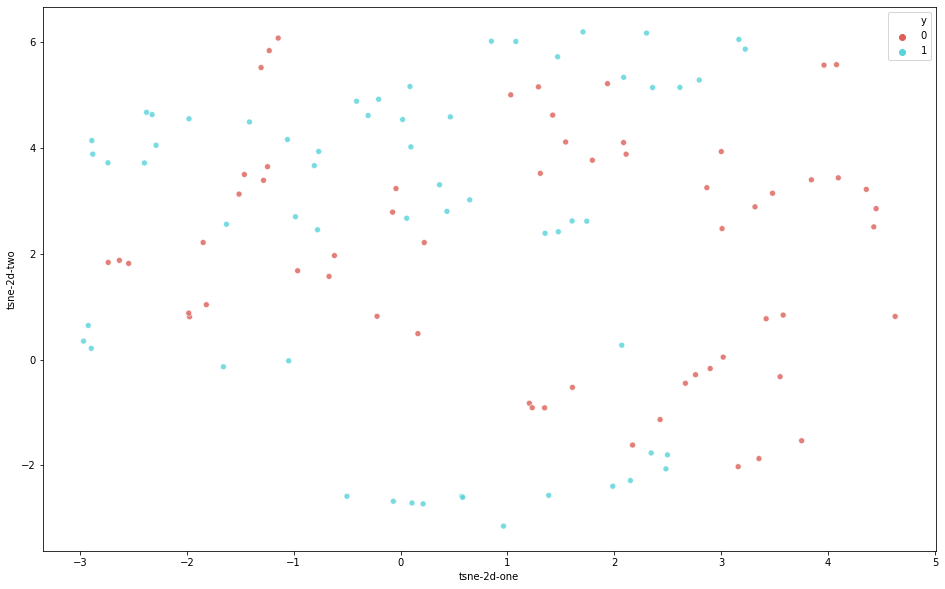

In [47]:
# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1250)
tsne_results = tsne.fit_transform(data_stack)

# Plot
df_stack['tsne-2d-one'] = tsne_results[:, 0]
df_stack['tsne-2d-two'] = tsne_results[:, 1]
# Labels
NUM_SAMPLES_PER_LABEL = 60
y = [1] * NUM_SAMPLES_PER_LABEL + [0] * NUM_SAMPLES_PER_LABEL
df_stack['y'] = y
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_stack,
    legend="full",
    alpha=0.8
)

### Playground: Multiple t-SNEs

In [ ]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)

for niter in range(250, 1500, 250):
    for perp in range(10, 55, 10):
        # multiple t-SNEs
        tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=niter)
        tsne_results = tsne.fit_transform(data_stack)

        coord_prefix = 'tsne-2d-'
        coord_desc = str(niter) + '-' + str(perp)
        x_coord = coord_prefix + coord_desc + '-one'
        y_coord = coord_prefix + coord_desc + '-two'
        df_stack[x_coord] = tsne_results[:, 0]
        df_stack[y_coord] = tsne_results[:, 1]

        # Labels
        NUM_SAMPLES_PER_LABEL = 60
        y = [1] * NUM_SAMPLES_PER_LABEL + [0] * NUM_SAMPLES_PER_LABEL
        df_stack['y'] = y

        niter_offset = int((niter-250)/250)
        perp_offset = int((perp-10)/10)
        fig.add_subplot(spec[niter_offset, perp_offset])
        sns.scatterplot(
            x=x_coord, y=y_coord,
            hue="y",
            palette=sns.color_palette("hls", 2),
            data=df_stack,
            legend="full",
            alpha=0.8,
        )

## PCA Clustering of Samples

Explained variation per principal component: [3.16458366e-01 2.27506635e-01 1.09504819e-01 7.96778395e-02
 5.86685039e-02 3.19953188e-02 2.82419430e-02 2.30697972e-02
 1.85083446e-02 1.58963822e-02 1.37279919e-02 9.86027769e-03
 8.43504676e-03 7.78370048e-03 6.29074759e-03 6.13033857e-03
 5.32843536e-03 4.81666648e-03 3.76310428e-03 3.24495556e-03
 2.69522725e-03 2.27659778e-03 1.90370219e-03 1.43345752e-03
 1.33508496e-03 1.10710832e-03 1.05758265e-03 1.01979147e-03
 8.90402268e-04 7.84842471e-04 6.27304260e-04 5.77732916e-04
 5.67533236e-04 4.61704005e-04 4.00865262e-04 3.54548393e-04
 3.28437713e-04 2.85040463e-04 2.47919133e-04 2.33909429e-04
 2.21855569e-04 1.95278689e-04 1.58501689e-04 1.39251847e-04
 1.26516433e-04 1.17981869e-04 1.11284496e-04 1.00437836e-04
 8.59695205e-05 8.17112699e-05]
Sum: 0.9988367952404746


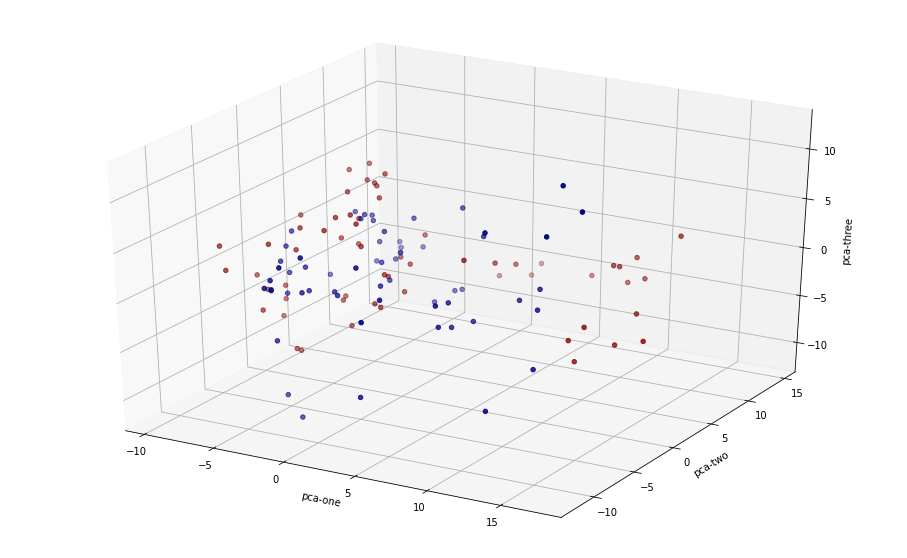

In [48]:
# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(data_stack)
df_stack['pca-one'] = pca_result[:,0]
df_stack['pca-two'] = pca_result[:,1] 
df_stack['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum:', sum(pca.explained_variance_ratio_))
## Explained variation per principal component: [0.1557712  0.11314638 0.08842925]

# Labels
NUM_SAMPLES_PER_LABEL = 60
y = [1] * NUM_SAMPLES_PER_LABEL + [0] * NUM_SAMPLES_PER_LABEL
df_stack['y'] = y

# Plot
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_stack["pca-one"], 
    ys=df_stack["pca-two"], 
    zs=df_stack["pca-three"], 
    c=df_stack["y"], 
    cmap='jet'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Inference via KNN in PCA Space

## Imports

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Embed Sample into PCA Space

In [49]:
def embed_pca(raw_eeg, pca_components):
    """
    Embeds RAW_EEG into the PCA representation space given by PCA_COMPONENTS
    """
    return np.dot(pca_components, raw_eeg.T).T

In [50]:
# pca_components = pca.components_
# print(pca_components.shape)
# data_stack_pca = np.dot(pca_components, data_stack.T).T
data_stack_pca = embed_pca(data_stack, pca.components_)
print(data_stack_pca.shape)
test_stack_pca = embed_pca(test_stack, pca.components_)
print(test_stack_pca.shape)

(120, 50)
(72, 50)


### Playground: Embedding one sample into PCA Space

In [ ]:
# Procedure for obtaining one sample's representation in PCA space
sample = data_stack[0,:]
print(sample.shape)
sample_rep = np.dot(pca_components, sample)

## KNN Classifier

### Playground: Test Different k-values

In [52]:
k_range = range(1, 51)
scores_list = []
TEST_TO_TRAIN_WEIGHT = 5
total_stack_pca = np.concatenate(
    (np.tile(test_stack_pca,
             (TEST_TO_TRAIN_WEIGHT, 1)),
     data_stack_pca))
total_labels = np.concatenate(
    (np.tile(test_labels,
             (TEST_TO_TRAIN_WEIGHT)),
     train_labels))
print(total_stack_pca.shape)
print(total_labels.shape)
for k_val in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(data_stack_pca, train_labels)
    knn_predict = knn.predict(test_stack_pca)
    scores_list.append(metrics.accuracy_score(test_labels, knn_predict))

print('Maximum accuracy is %f' % (np.amax(scores_list)))

(480, 50)
(480,)
Maximum accuracy is 0.638889


### Plot KNN Results

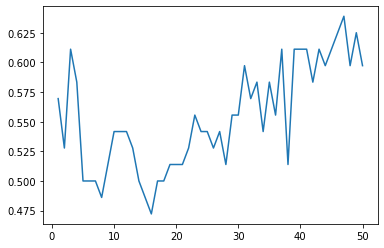

In [53]:
sns.lineplot(x=k_range, y=scores_list)

# Neural Network Approaches

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Read in Data to tf.data.Dataset

### Read into Numpy Array

#### Training Data

In [33]:
train_root = 'csvc/'
test_root = 'csvc/'
train_number = range(1, 6)
test_number = range(6, 9)

In [34]:
data_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
# print(data_stack.shape)

for l in label:
    for trial in train_number:
        path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
#         print(df.shape)

        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
#         print(data_stack.shape)
        
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

Dropped NaN: 
 [[723   0]
 [723   1]
 [723   2]
 [723   3]
 [723   4]
 [723   5]
 [723   6]
 [723   7]
 [723   8]
 [723   9]
 [723  10]
 [723  11]
 [723  12]
 [723  13]
 [723  14]
 [723  15]
 [723  16]
 [723  17]
 [723  18]
 [723  19]]
Dropped NaN: 
 [[ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]]
Dropped NaN: 
 [[187   0]
 [187   1]
 [187   2]
 [187   3]
 [187   4]
 [187   5]
 [187   6]
 [187   7]
 [187   8]
 [187   9]
 [187  10]
 [187  11]
 [187  12]
 [187  13]
 [187  14]
 [187  15]
 [187  16]
 [187  17]
 [187  18]
 [187  19]]
Dropped NaN: 
 [[   1    0]
 [   1    1]
 [   1    2]
 [   1    3]
 [   1    4]
 [   1    5]
 [   1    6]
 [   1    7]
 [   1    8]
 [   1    9]
 [   1   10]
 [   1   11]
 [   1   12]
 [   1   13]
 [   1   14]
 [   1   15]
 [   1   16]
 [   1   17]
 [   1   18]
 [   1   19]
 [2160    0]
 [2160    1]
 [2160    2]
 [2160    3]
 [216

#### Testing

In [35]:
test_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
for l in label:
    for trial in test_number:
        path = test_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
            test_stack = np.concatenate((test_stack, raw_vals), axis=0)
#             print(test_stack.shape)
# df_test = pd.DataFrame(test_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("test_stack shape: ", test_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(test_stack))) == 0)  # Should be empty

Dropped NaN: 
 [[  73    0]
 [  73    1]
 [  73    2]
 [  73    3]
 [  73    4]
 [  73    5]
 [  73    6]
 [  73    7]
 [  73    8]
 [  73    9]
 [  73   10]
 [  73   11]
 [  73   12]
 [  73   13]
 [  73   14]
 [  73   15]
 [  73   16]
 [  73   17]
 [  73   18]
 [  73   19]
 [2232    0]
 [2232    1]
 [2232    2]
 [2232    3]
 [2232    4]
 [2232    5]
 [2232    6]
 [2232    7]
 [2232    8]
 [2232    9]
 [2232   10]
 [2232   11]
 [2232   12]
 [2232   13]
 [2232   14]
 [2232   15]
 [2232   16]
 [2232   17]
 [2232   18]
 [2232   19]]
Dropped NaN: 
 [[ 9  0]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 12]
 [ 9 13]
 [ 9 14]
 [ 9 15]
 [ 9 16]
 [ 9 17]
 [ 9 18]
 [ 9 19]
 [62  0]
 [62  1]
 [62  2]
 [62  3]
 [62  4]
 [62  5]
 [62  6]
 [62  7]
 [62  8]
 [62  9]
 [62 10]
 [62 11]
 [62 12]
 [62 13]
 [62 14]
 [62 15]
 [62 16]
 [62 17]
 [62 18]
 [62 19]]
test_stack shape:  (72, 128, 20)
confirm no NaN: True


#### Labels

In [36]:
# Labels
train_labels = np.concatenate(
    (np.tile([0, 1], (TRAIN_SAMPLES, 1)),
     np.tile([1, 0], (TRAIN_SAMPLES, 1)))
)
test_labels = np.concatenate(
    (np.tile([0, 1], (TEST_SAMPLES, 1)),
     np.tile([1, 0], (TEST_SAMPLES, 1)))
)

### Create tf.data.Dataset from tensor slices

In [39]:
FULL_DATASET_SIZE = 120
TRAIN_SIZE = int(FULL_DATASET_SIZE * 0.8)
VALIDATION_SIZE = int(FULL_DATASET_SIZE * 0.2)

TRAIN_BATCH_SIZE = 4
VALIDATION_BATCH_SIZE = 1

full_dataset = tf.data.Dataset.from_tensor_slices(
    (data_stack, train_labels)
).shuffle(FULL_DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE).batch(TRAIN_BATCH_SIZE)
validation_dataset = full_dataset.skip(TRAIN_SIZE).take(VALIDATION_SIZE).batch(VALIDATION_BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_stack, test_labels))
TEST_SHUFFLE_BUFFER = 16
TEST_BATCH_SIZE = 1
test_dataset = test_dataset.shuffle(TEST_SHUFFLE_BUFFER).batch(TEST_BATCH_SIZE)

In [40]:
print(train_dataset, validation_dataset, test_dataset)

<BatchDataset shapes: ((None, 128, 20), (None, 2)), types: (tf.float64, tf.int32)> <BatchDataset shapes: ((None, 128, 20), (None, 2)), types: (tf.float64, tf.int32)> <BatchDataset shapes: ((None, 128, 20), (None, 2)), types: (tf.float64, tf.int32)>


## Build the Model with Keras

### A Basic Convolutional Neural Network

In [41]:
input_shape = (int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS, 1)
inputs = keras.Input(shape=input_shape)
# A proposed architecture is to use recurrent first to "summarize,"
    # No need for embedding layer in recurrent subnetwork?
# then use convolutional to classify.


first_conv = layers.Conv2D(16, 3, activation='relu')
first_pool = layers.MaxPool2D(pool_size=(2, 1))
second_conv = layers.Conv2D(32, 3, activation='relu')
second_pool = layers.MaxPool2D(pool_size=(2, 1))
third_conv = layers.Conv2D(64, 3, activation='relu')
flattener = layers.Flatten()
first_dense = layers.Dense(64, activation='relu')
second_dense = layers.Dense(16, activation='relu')
third_dense = layers.Dense(2)

outputs = third_dense(
    second_dense(first_dense(
        flattener(
            third_conv(
                second_pool(second_conv(
                    first_pool(first_conv(inputs)))))))))

model = keras.Model(inputs=inputs, outputs=outputs, name='simple_conv')
model.summary()

Model: "simple_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 20, 1)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 18, 16)       160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 18, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             

### A Recurrent-->Convolutional Neural Network

### Compile Model

In [42]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [43]:
history = model.fit(train_dataset, epochs=10, verbose=1, validation_data=validation_dataset)

Epoch 1/10
24/24 [==============================] - 1s 50ms/step - loss: 0.6976 - accuracy: 0.4583 - val_loss: 0.6570 - val_accuracy: 0.5417
Epoch 2/10
24/24 [==============================] - 1s 23ms/step - loss: 0.6566 - accuracy: 0.6354 - val_loss: 0.6426 - val_accuracy: 0.6250
Epoch 3/10
24/24 [==============================] - 0s 20ms/step - loss: 0.7033 - accuracy: 0.6042 - val_loss: 0.6201 - val_accuracy: 0.7083
Epoch 4/10
24/24 [==============================] - 0s 17ms/step - loss: 0.5912 - accuracy: 0.6667 - val_loss: 0.4465 - val_accuracy: 0.7917
Epoch 5/10
24/24 [==============================] - 1s 23ms/step - loss: 0.4935 - accuracy: 0.6979 - val_loss: 0.4608 - val_accuracy: 0.7500
Epoch 6/10
24/24 [==============================] - 0s 21ms/step - loss: 0.4373 - accuracy: 0.7500 - val_loss: 0.2636 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 0s 20ms/step - loss: 0.4084 - accuracy: 0.7917 - val_loss: 0.6957 - val_accuracy: 0.5833
Epoch 8/10
24

## Test Model

In [44]:
test_loss, test_acc = model.evaluate(test_dataset)

72/72 [==============================] - 0s 6ms/step - loss: 2.7863 - accuracy: 0.3750
